# Shikhar Soni - 2019CSB1119
# CS517 Course Project
________________________________________________________________________________________________________________________________

## Implement dehazing algorithm as described in the paper shared with us
### 1. Segmentation 

In [126]:
from matplotlib import pyplot as plt
from PIL import Image
import cv2
import numpy as np
from math import floor, ceil, exp
from scipy import ndimage

In [127]:
load_Image = Image.open('house-input.bmp')

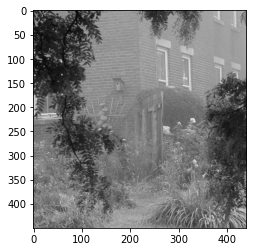

In [128]:
img = load_Image.convert('L')
img = np.array(img)
# rescale image between 0 and 1
def rescale(img):
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img
img = rescale(img)

plt.imshow(img, 'gray')

In [129]:
def Segmentation(img, patch_box=3, k=15):
    height, width = img.shape

    # haze distribution map
    V = np.zeros(img.shape)

    # divide into patches of patch_box X patch_box (approx)
    for i in range(0, height, patch_box):
        for j in range(0, width, patch_box):
            patch_i = img[i:min(i+patch_box, height), j:min(j+patch_box, width)]
            Vi = np.mean(patch_i) - np.std(patch_i)
            V[i:min(i+patch_box, height), j:min(j+patch_box, width)] = Vi
        
    Vvec = V.flatten()
    Vvec = list(Vvec)
    Vvec.sort()
    
    range_ = []
    l_ = height * width # resolution
    
    assert(len(list(Vvec)) == l_)
    for i in range(1, k + 1):
        fr = ((i - 1) * (l_ - 1))//k
        en = (i * (l_ - 1))//k
        range_.append((max(fr, 0), en, i)) 
    
    C = np.zeros(img.shape)
    # segment image into scenes
    for i in range(height):
        for j in range(width):
            for x, y, z in range_:
                if(Vvec[x] <= V[i, j] <= Vvec[y]):
                    C[i, j] = z
                    break
                    
    return C.astype('int'), V
    

In [130]:
C, V = Segmentation(img, patch_box=3, k=15)

### Segmentation result for k=15 and patch_size of approx 5X5

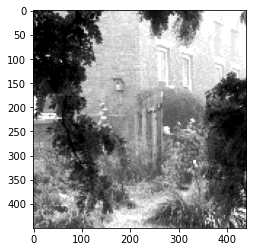

In [131]:
plt.imshow(C, cmap='gray')

### 2. Scence luminance Map Estimation

In [132]:
def sceneLuminance(C, I, erosion_box=3, k=15):
    
    height, width = I.shape
    
    # erode the image
    kernel = np.ones((erosion_box, erosion_box), dtype=np.uint8)
    I = cv2.erode(I, kernel)
    
    # get the top 10% (0.1) brightest pixel average in a scene
    scene_intensity = [[] for i in range(k)]
    
    for i in range(height):
        for j in range(width):
            scene_intensity[C[i, j] - 1].append(I[i, j])
    
    # calculate scene luminance for all scenes
    scene_luminance = []
    for i in range(k):
        scene_intensity[i].sort(reverse=True)
        # find mean of max 10% (0.1) of pixels
        len_ = int(round(len(scene_intensity[i]) * 0.1, 0))
        scene_luminance.append(np.mean(scene_intensity[i][:len_]))
    
    scene_luminance_map = np.zeros(I.shape)
    for i in range(height):
        for j in range(width):
            scene_luminance_map[i, j] = scene_luminance[C[i, j] - 1]
    
    return scene_luminance_map

In [133]:
img_c = load_Image.convert('RGB')
R, G, B = img_c.split()
R, G, B = rescale(np.array(R)), rescale(np.array(G)), rescale(np.array(B))

Lr = sceneLuminance(C, R)
Lg = sceneLuminance(C, G)
Lb = sceneLuminance(C, B)

### Scene luminance map for {R, G, B} channels of the image

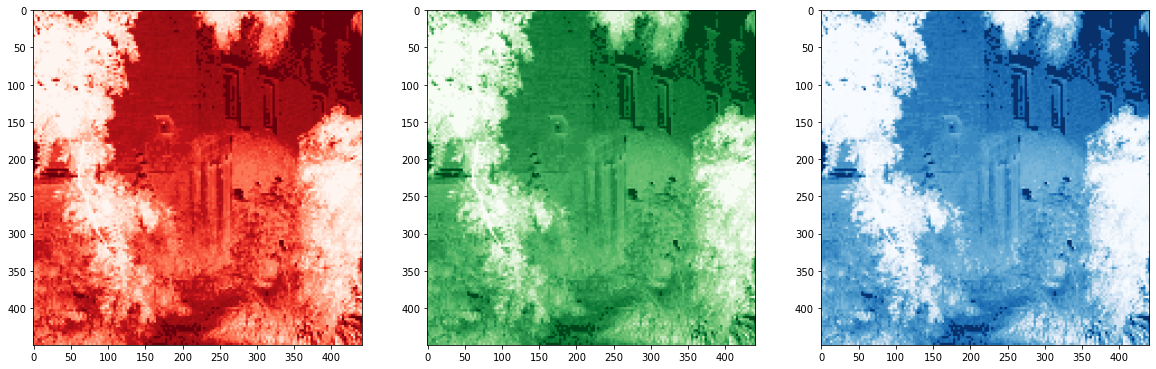

In [134]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(Lr, 'Reds')

plt.subplot(1, 3, 2)
plt.imshow(Lg, 'Greens')

plt.subplot(1, 3, 3)
plt.imshow(Lb, 'Blues')

### 3. Transmission map estimation

In [135]:
def delImage(I):
    sx = ndimage.sobel(I, axis=0, mode='reflect')
    sy = ndimage.sobel(I, axis=1, mode='reflect')
    sobel = np.hypot(sx, sy)
    return sobel

def sceneTransmission(C, R, G, B, Lr, Lg, Lb, V, iter_=100, k=15, w=0.15):
    
    height, width = C.shape
    
    temp_resR = np.divide(R - Lr, Lr)
    temp_resG = np.divide(G - Lg, Lg)
    temp_resB = np.divide(B - Lb, Lb)
    
    list_ = [temp_resR, temp_resG, temp_resB]
    
    delta = 0.9 / iter_  #[0.1, 1.0]
    
    reference = [0 for i in range(k)]
    Tis = [0 for i in range(k)]
    
    # calculate T cap(i)
    for i in range(iter_ + 1):
        Ti = i * delta + 0.1
        
        Val = 0
        for x in list_:
            Val += delImage(1 + x / Ti)
        
        ith_iter = [0 for j in range(k)]
        for l in range(height):
            for w in range(width):
                ith_iter[C[l, w] - 1] += Val[l, w]
        
        for j in range(k):
            if(ith_iter[j] > reference[j]):
                Tis[j] = Ti
                reference[j] = ith_iter[j]
    
    # separatin V into different scenes
    Xi = [[] for i in range(k)]
    for i in range(height):
        for j in range(width):
            Xi[C[i, j] - 1].append(V[i, j])
            
    for i in range(k):
        # calculatin Xi
        Xi[i] = np.mean(np.array(Xi[i]))
    
    Mi = [0 for i in range(k)]
    for i in range(k):
        # calculating M(i)
        Mi[i] = 2 - exp(-((Xi[i] - 0.5)**2/(2 * w ** 2)))
        
    T = np.zeros(C.shape)
    for i in range(height):
        for j in range(width):
            # T(i) = T_cap(i) * M(i)
            T[i, j] = Mi[C[i, j] - 1] * Tis[C[i, j] - 1]
        
    return T


In [136]:
T = sceneTransmission(C, R, G, B, Lr, Lg, Lb, V)

### Scene transmission map result w=0.15

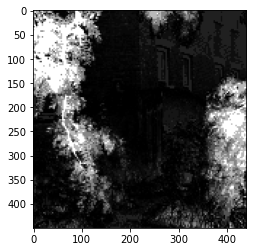

In [137]:
plt.imshow(T, 'gray')

### 4. Edge Optimization Method

In [138]:
lh, lw = img.shape
alpha = 3
beta = 3 # 3*(iter-1)
gamma = 4
r = max(lh, lw)//15

def edgeOptimization(G, T, Ref):
    
    # calculating W
    W = 1 - np.exp(-delImage(G))
    
    # pre calculated 2 terms of the numerator as mentioned in paper
    G_ref = (r**2 - 1) * G - cv2.boxFilter(G, normalize=False, ddepth=-1, ksize=(r, r), borderType=cv2.BORDER_REFLECT) - G
    Numerator = alpha * T + gamma * W * (G_ref)
    
    T_ref = Ref
    iter_ = 0
    while(True):
        beta = 3 * iter_ # 3 * (iter_ + 1 - 1)
        iter_ += 1
        # variable portion of the numerator
        Top_ = Numerator + (W * (gamma - beta) + beta) * (cv2.boxFilter(T_ref, normalize=False, ddepth=-1, ksize=(r, r), borderType=cv2.BORDER_REFLECT) - T_ref)
        # iteration result
        T_ref_p = T_ref
        T_ref = Top_ / (alpha + (r**2 - 1) * (W * (gamma - beta) + beta))
        
        # break condition as specified in the paper
        break_cond = (T_ref - T_ref_p) ** 2 / (lh * lw)
        if(np.sum(break_cond) <= 0.0001):
            break
        
        
        
    return T_ref

In [139]:
# transmission map refined
T_r = edgeOptimization(img, T, T)
# luminance map refined
Lr_r = edgeOptimization(img, T, Lr)
Lg_r = edgeOptimization(img, T, Lg)
Lb_r = edgeOptimization(img, T, Lb)

### Edge optimization of Lr, Lg, Lb and T

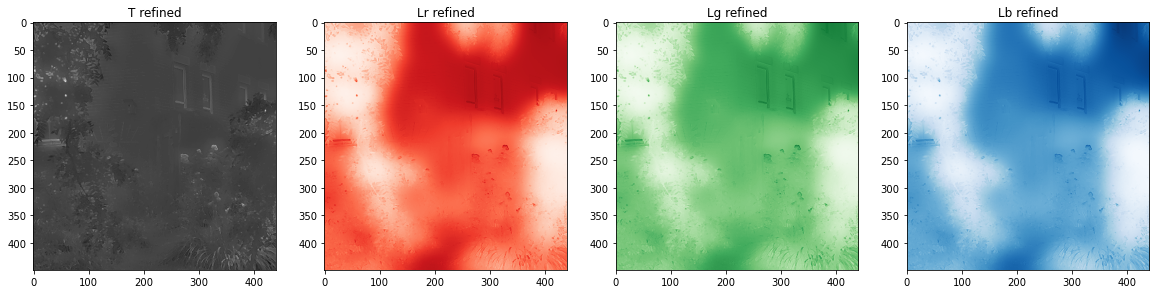

In [140]:
plt.figure(figsize=(20, 20))

plt.subplot(1, 4, 1)
plt.title('T refined')
plt.imshow(T_r, 'gray')

plt.subplot(1, 4, 2)
plt.title('Lr refined')
plt.imshow(Lr_r, 'Reds')

plt.subplot(1, 4, 3)
plt.title('Lg refined')
plt.imshow(Lg_r, 'Greens')

plt.subplot(1, 4, 4)
plt.title('Lb refined')
plt.imshow(Lb_r, 'Blues')

### 5. Image restoration

In [141]:
def restoration(R, G, B, Lr_r, Lg_r, Lb_r, T_r):
    
    pr = 1 + (R - Lr_r) / (Lr_r * T_r)
    pg = 1 + (G - Lg_r) / (Lg_r * T_r)
    pb = 1 + (B - Lb_r) / (Lb_r * T_r)
    
    def clip_input_0to1(a):
        a[a > 1] = 1
        a[a < 0] = 0
        return a
    
    # min-max operation on the obtained reflectance
    Rr = clip_input_0to1(pr)
    Rg = clip_input_0to1(pg)
    Rb = clip_input_0to1(pb)
    
    # rejoining channels (RGB)
    rgb = np.dstack((Rr, Rg, Rb))

    return rgb
    

### Restored Image

In [142]:
result = restoration(R, G, B, Lr_r, Lg_r, Lb_r, T_r)

Text(0.5, 1.0, 'Resultant Image')

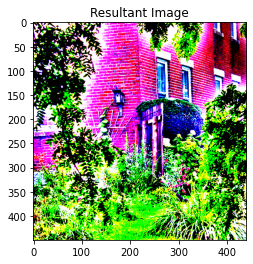

In [143]:
plt.imshow(result)
plt.title('Resultant Image')